Feature는 적지만 데이터가 많은 대규모 데이터 분석 경험을 목표로 해당 프로젝트를 기획.<br>
데이터 셋은 H-1B, H-1B1, E-3의 3가지 비자 프로그램으로 구성되어 있다.

### H-1B 비자

 고용주들이 비이민적인 직업으로 미국에 있는 외국인 근로자들을 일시적으로 고용하거나 뛰어난 공로와 능력을 갖춘 패션 모델로 고용할 수 있게 해준다. 전문직은 전문적 지식과 학사 또는 이와 동등한 학위의 특정 전문분야(예: 과학, 의학, 의료, 교육, 생명공학, 비즈니스 전문분야 등)의 이론적이고 실질적인 적용을 필요로 한다.

### H-1B1(칠레와 싱가포르)

고용주들이 미국에 있는 칠레와 싱가포르에서 온 외국인 근로자들을 비이민적인 직업으로 임시 고용할 수 있도록 한다.

### E-3(호주)

고용주들이 미국에서 비이민적인 기반으로 전문직종에서 호주 출신의 외국인 근로자들을 임시로 고용할 수 있도록 허용한다.

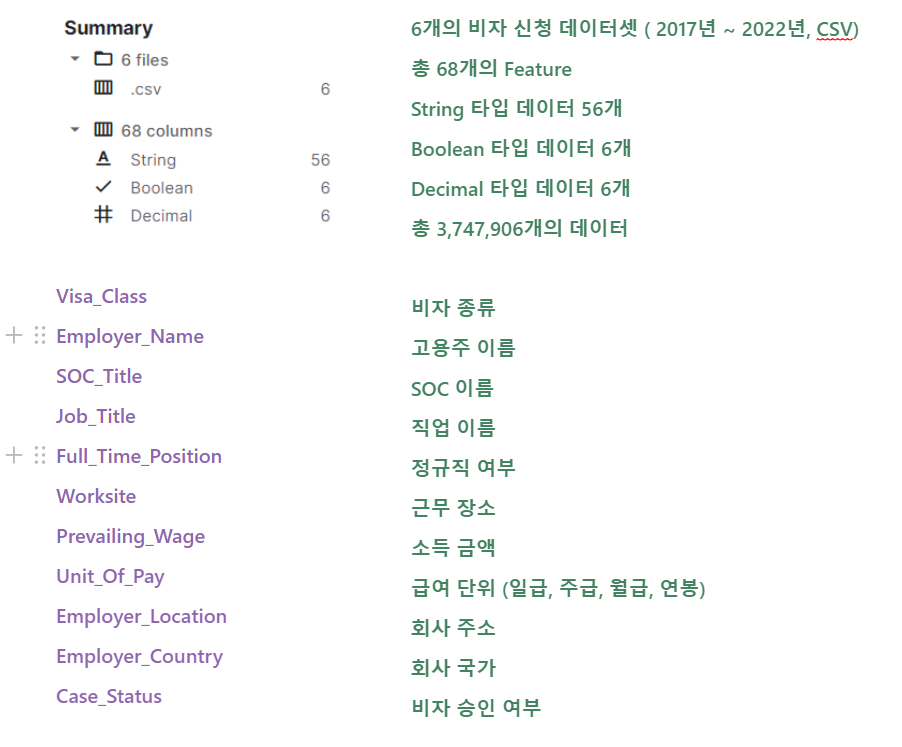

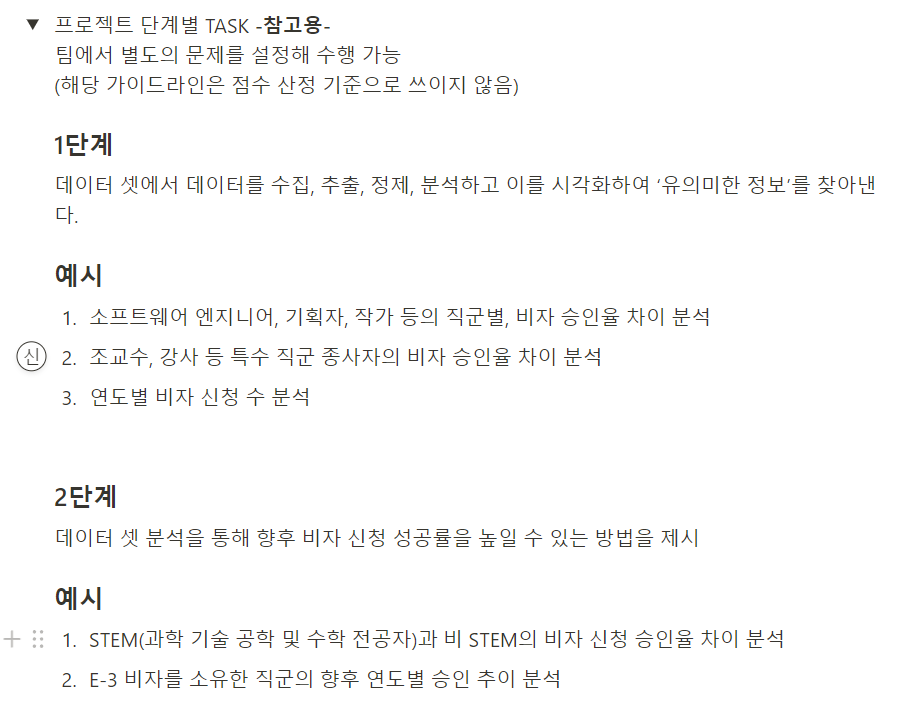

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

$ conda install -c conda-forge xgboost=1.3.3

$ conda install -c conda-forge lightgbm=3.1.1 

$ conda install -c conda-forge missingno=0.4.2

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/LCA_FY'

data_2017_path = join(data_dir, 'LCA_FY_2017.csv')
print(data_2017_path)

/aiffel/aiffel/LCA_FY/LCA_FY_2017.csv


In [38]:
data_2017 = pd.read_csv(data_2017_path)

<AxesSubplot:>

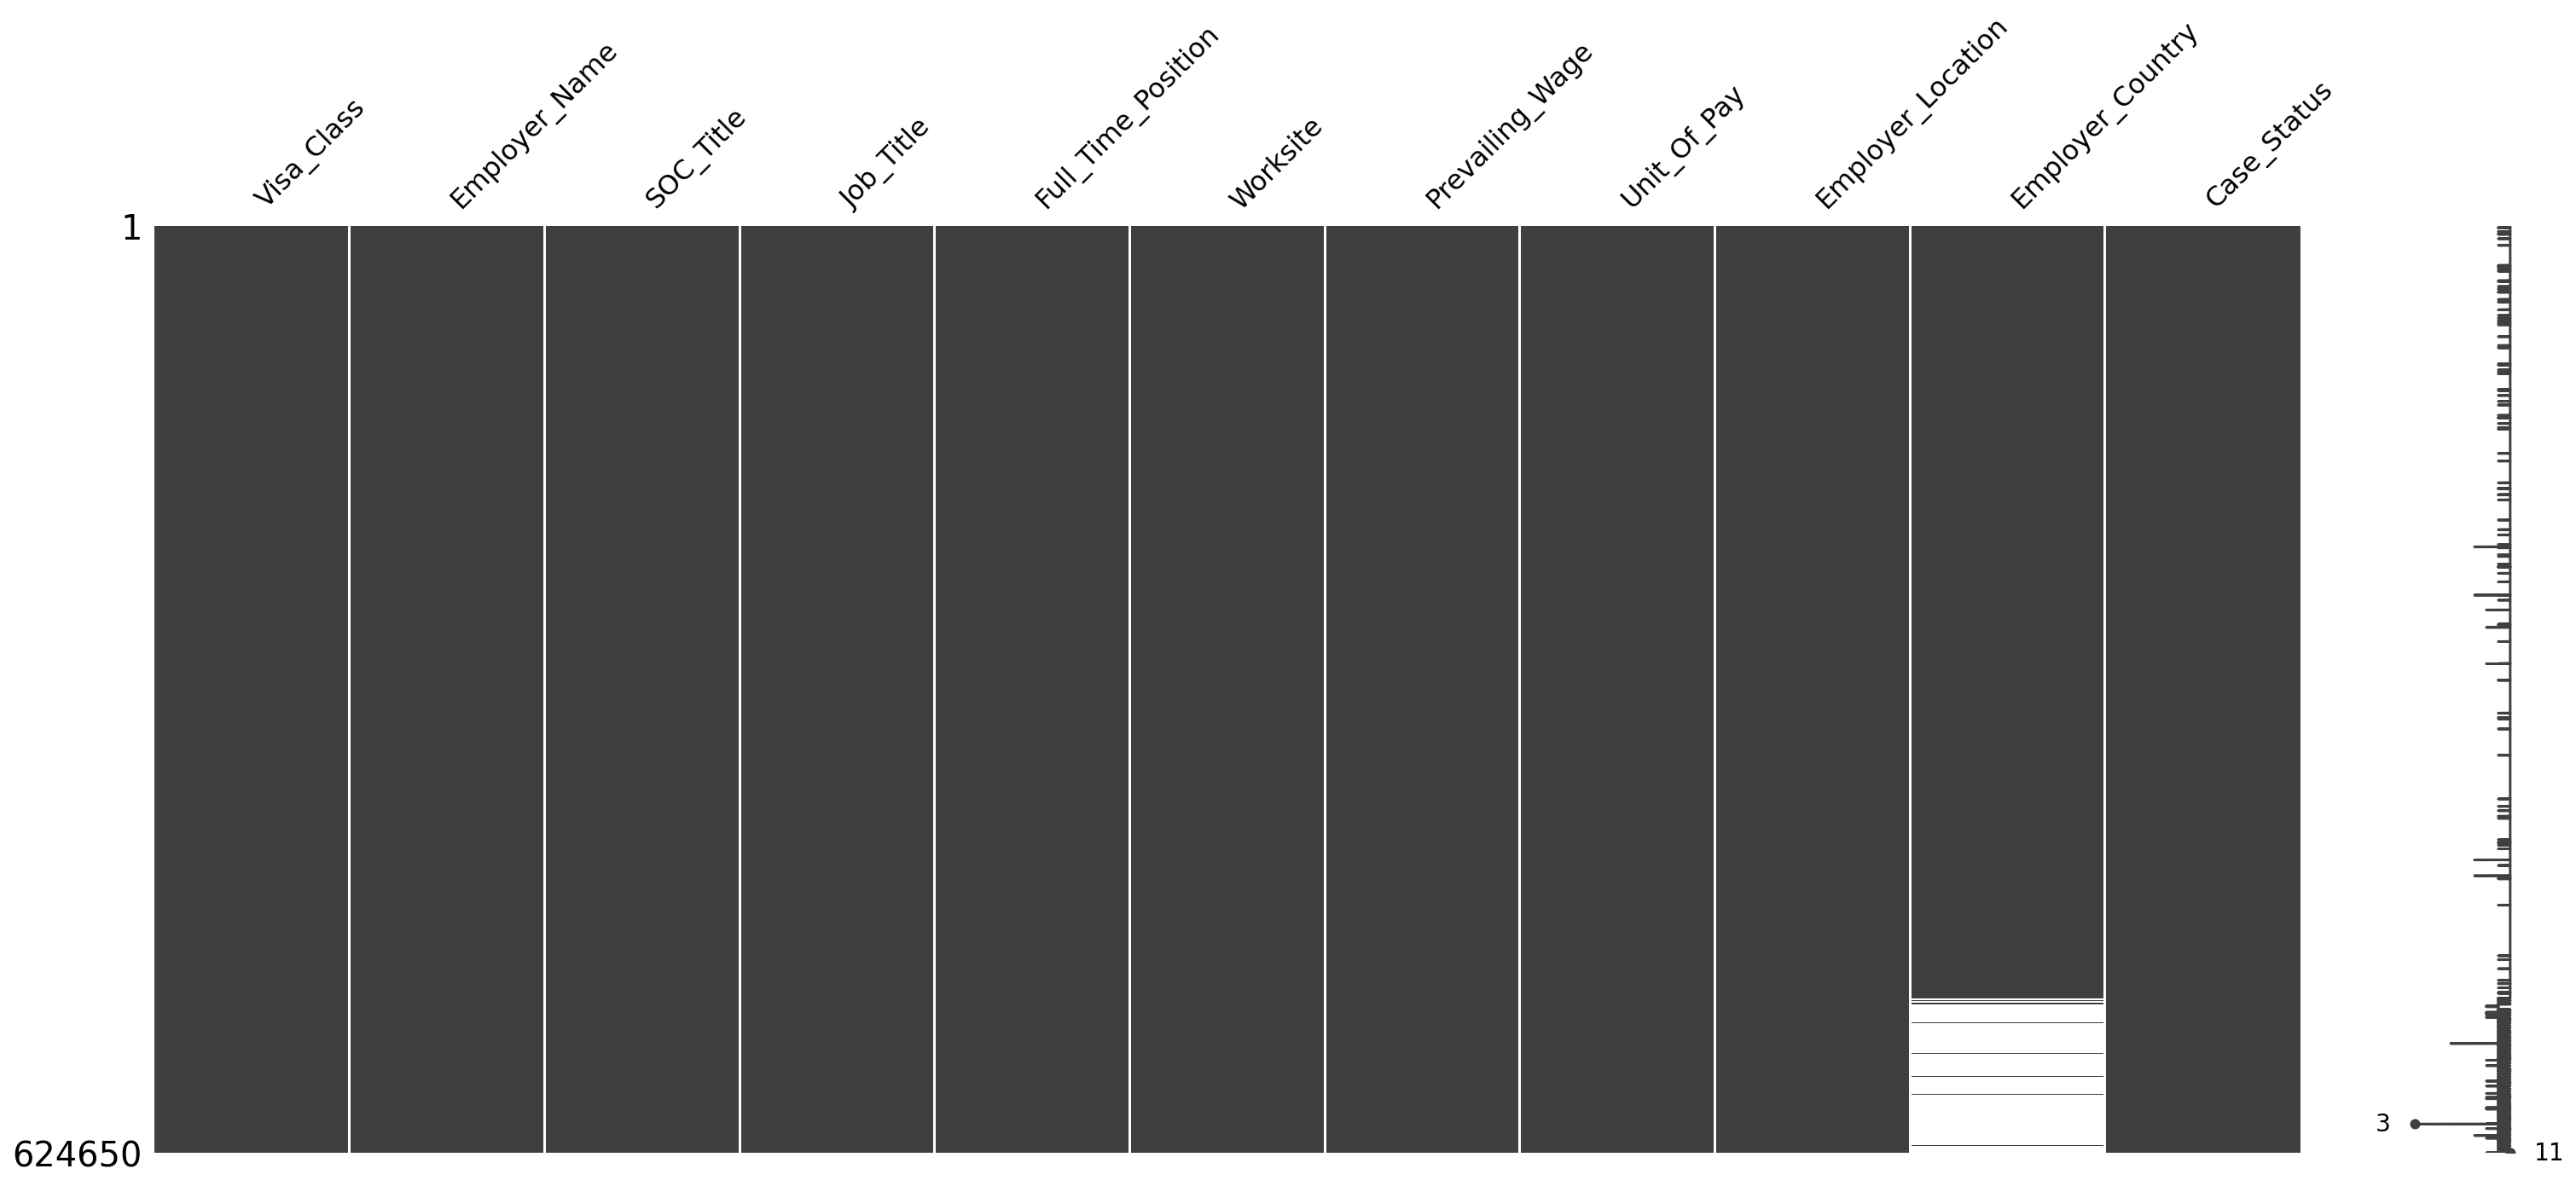

In [5]:
msno.matrix(data_2017) # 결측치 확인

### 데이터 불러오기 

In [6]:
data_2017 = pd.read_csv(data_2017_path)
print('train data dim : {}'.format(data_2017.shape))

temp = data_2017.copy()

train data dim : (624650, 11)


In [7]:
temp.isnull().sum()

Visa_Class                0
Employer_Name            56
SOC_Title                 3
Job_Title                 5
Full_Time_Position        5
Worksite                 21
Prevailing_Wage           1
Unit_Of_Pay              46
Employer_Location        30
Employer_Country      96507
Case_Status               0
dtype: int64

In [8]:
temp = temp.drop('Job_Title', axis= 1)
temp = temp.drop('Employer_Country',axis =1)
temp = temp.drop(temp[(temp['Employer_Name'].isnull()) | (temp['SOC_Title'].isnull()) | (temp['Full_Time_Position'].isnull()) | (temp['Prevailing_Wage'].isnull()) | (temp['Unit_Of_Pay'].isnull())].index)
temp = temp.drop(temp[temp['Employer_Location'].isnull()].index)
temp.isnull().sum()

Visa_Class             0
Employer_Name          0
SOC_Title              0
Full_Time_Position     0
Worksite              16
Prevailing_Wage        0
Unit_Of_Pay            0
Employer_Location      0
Case_Status            0
dtype: int64

In [9]:
temp['Worksite']=temp['Worksite'].fillna(temp['Employer_Location'])

In [10]:
temp.isnull().sum()

Visa_Class            0
Employer_Name         0
SOC_Title             0
Full_Time_Position    0
Worksite              0
Prevailing_Wage       0
Unit_Of_Pay           0
Employer_Location     0
Case_Status           0
dtype: int64

In [11]:
temp[temp['Employer_Name'] == 'DISCOVER PRODUCTS INC.']

,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status
0,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",59197.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN
360,H-1B,DISCOVER PRODUCTS INC.,Statisticians,Y,"Riverwoods, Illinois",66643.0,Year,"Riverwoods, Illinois",CERTIFIED
1163,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",72197.0,Year,"Riverwoods, Illinois",CERTIFIED
3986,H-1B,DISCOVER PRODUCTS INC.,Statisticians,Y,"Riverwoods, Illinois",82056.0,Year,"Riverwoods, Illinois",CERTIFIED
5700,H-1B,DISCOVER PRODUCTS INC.,Operations Research Analysts,Y,"Riverwoods, Illinois",76086.0,Year,"Riverwoods, Illinois",CERTIFIED
...,...,...,...,...,...,...,...,...,...
609173,H-1B,DISCOVER PRODUCTS INC.,Operations Research Analysts,Y,"Riverwoods, Illinois",78790.0,Year,"Riverwoods, Illinois",CERTIFIED
612411,H-1B,DISCOVER PRODUCTS INC.,Marketing Managers,Y,"Riverwoods, Illinois",137634.0,Year,"Riverwoods, Illinois",CERTIFIED
614196,H-1B,DISCOVER PRODUCTS INC.,Statisticians,Y,"Phoenix, Arizona",74277.0,Year,"Riverwoods, Illinois",CERTIFIED
623420,H-1B,DISCOVER PRODUCTS INC.,Market Research Analysts And Marketing Special...,Y,"Riverwoods, Illinois",52645.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN


#### 전체 데이터 4개

1.  결측치 보완하기 
2. 무엇을 타겟으로 잡을 것인가 생각하기 (Case_Status : 비자 승인 여부) 0: CERTIFIED 1: DENIED 2: WITHDRAWN 3: CERTIFIED-WITHDRAWN
3. 특이사항 : 2020 년 자료와 2021 년 자료에는 Quarter(분기) 라는 string 형 feature 가있다. 
4. Decimal 타입 데이터: Prevailing
5. Boolean 타입 데이터 :Full_time 
6. 중복값 정리하기
7. Prevailing_Wage 임금
8.  Unit_Of_Pay : 급여 단위 (일급, 주급, 월급, 연봉)
9.  : Job_Title: 직업 이름
10. Full_Time_Position : 



생각해야 할것.

In [12]:
temp.head()

,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status
0,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",59197.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN
1,H-1B,DFS SERVICES LLC,Operations Research Analysts,Y,"Riverwoods, Illinois",49800.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN
2,H-1B,EASTBANC TECHNOLOGIES LLC,Computer Programmers,Y,"Washington, District of Columbia",76502.0,Year,"Washington, District of Columbia",CERTIFIED-WITHDRAWN
3,H-1B,INFO SERVICES LLC,"Computer Occupations, All Other",Y,"Jersey City, New Jersey",90376.0,Year,"Livonia, Michigan",WITHDRAWN
4,H-1B,BB&T CORPORATION,Credit Analysts,Y,"New York, New York",116605.0,Year,"Wilson, North Carolina",CERTIFIED-WITHDRAWN


타겟 데이터를 정하자.

In [13]:
X = temp
print(X.shape)
X.head()

(624519, 9)


,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status
0,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",59197.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN
1,H-1B,DFS SERVICES LLC,Operations Research Analysts,Y,"Riverwoods, Illinois",49800.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN
2,H-1B,EASTBANC TECHNOLOGIES LLC,Computer Programmers,Y,"Washington, District of Columbia",76502.0,Year,"Washington, District of Columbia",CERTIFIED-WITHDRAWN
3,H-1B,INFO SERVICES LLC,"Computer Occupations, All Other",Y,"Jersey City, New Jersey",90376.0,Year,"Livonia, Michigan",WITHDRAWN
4,H-1B,BB&T CORPORATION,Credit Analysts,Y,"New York, New York",116605.0,Year,"Wilson, North Carolina",CERTIFIED-WITHDRAWN


In [14]:
target = 'Case_Status'

In [15]:
X["Case_bool"]=X["Case_Status"].mask(X["Case_Status"]== "CERTIFIED", "True"  )  
X["Case_bool"]=X["Case_bool"].mask(X["Case_Status"]== "CERTIFIED-WITHDRAWN", "True"  )
X["Case_bool"]=X["Case_bool"].mask(X["Case_Status"]== "WITHDRAWN", "True"  )
X["Case_bool"]=X["Case_bool"].mask(X["Case_Status"]== "DENIED", "True"  )

In [16]:
X

,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status,Case_bool
0,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",59197.00,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN,True
1,H-1B,DFS SERVICES LLC,Operations Research Analysts,Y,"Riverwoods, Illinois",49800.00,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN,True
2,H-1B,EASTBANC TECHNOLOGIES LLC,Computer Programmers,Y,"Washington, District of Columbia",76502.00,Year,"Washington, District of Columbia",CERTIFIED-WITHDRAWN,True
3,H-1B,INFO SERVICES LLC,"Computer Occupations, All Other",Y,"Jersey City, New Jersey",90376.00,Year,"Livonia, Michigan",WITHDRAWN,True
4,H-1B,BB&T CORPORATION,Credit Analysts,Y,"New York, New York",116605.00,Year,"Wilson, North Carolina",CERTIFIED-WITHDRAWN,True
...,...,...,...,...,...,...,...,...,...,...
624645,H-1B,FAST SWITCH LTD,"Software Developers, Applications",Y,"Dublin, Ohio",37.12,Hour,"Dublin, Ohio",CERTIFIED-WITHDRAWN,True
624646,H-1B,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,Physicists,Y,"Cambridge, Massachusetts",50398.00,Year,"Cambridge, Massachusetts",CERTIFIED,True
624647,H-1B,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,"Geoscientists, Except Hydrologists And Geograp...",Y,"Cambridge, Massachusetts",61069.00,Year,"Cambridge, Massachusetts",CERTIFIED,True
624648,H-1B,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,Materials Engineers,Y,"Cambridge, Massachusetts",41392.00,Year,"Cambridge, Massachusetts",CERTIFIED,True


In [17]:
X[X["Case_bool"]== "1"]

,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status,Case_bool


In [18]:
X.dtypes

Visa_Class             object
Employer_Name          object
SOC_Title              object
Full_Time_Position     object
Worksite               object
Prevailing_Wage       float64
Unit_Of_Pay            object
Employer_Location      object
Case_Status            object
Case_bool              object
dtype: object

In [19]:
X.head(200)

,Visa_Class,Employer_Name,SOC_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Case_Status,Case_bool
0,H-1B,DISCOVER PRODUCTS INC.,Computer Systems Analysts,Y,"Riverwoods, Illinois",59197.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN,True
1,H-1B,DFS SERVICES LLC,Operations Research Analysts,Y,"Riverwoods, Illinois",49800.0,Year,"Riverwoods, Illinois",CERTIFIED-WITHDRAWN,True
2,H-1B,EASTBANC TECHNOLOGIES LLC,Computer Programmers,Y,"Washington, District of Columbia",76502.0,Year,"Washington, District of Columbia",CERTIFIED-WITHDRAWN,True
3,H-1B,INFO SERVICES LLC,"Computer Occupations, All Other",Y,"Jersey City, New Jersey",90376.0,Year,"Livonia, Michigan",WITHDRAWN,True
4,H-1B,BB&T CORPORATION,Credit Analysts,Y,"New York, New York",116605.0,Year,"Wilson, North Carolina",CERTIFIED-WITHDRAWN,True
...,...,...,...,...,...,...,...,...,...,...
195,H-1B,TATA CONSULTANCY SERVICES LIMITED,Web Developers,Y,"Hudson, Ohio",56784.0,Year,"Rockville, Maryland",CERTIFIED,True
196,H-1B,"HEALTH MANAGEMENT SYSTEMS, INC.","Software Developers, Applications",Y,"Irving, Texas",85197.0,Year,"Irving, Texas",CERTIFIED,True
197,H-1B,"BLACKROCK INVESTMENT MANAGEMENT, LLC","Software Developers, Applications",Y,"San Francisco, California",117770.0,Year,"New York, New York",CERTIFIED,True
198,H-1B,"UNIVERSITY OF CALIFORNIA, BERKELEY",Soil And Plant Scientists,Y,"Berkeley, California",66414.0,Year,"Berkeley, California",CERTIFIED,True


In [20]:
types = list(set(X["Visa_Class"]))
print(len(types))
print(types)

4
['H-1B1 Singapore', 'E-3 Australian', 'H-1B1 Chile', 'H-1B']


Text(0.5, 1.0, 'Visa_Class')

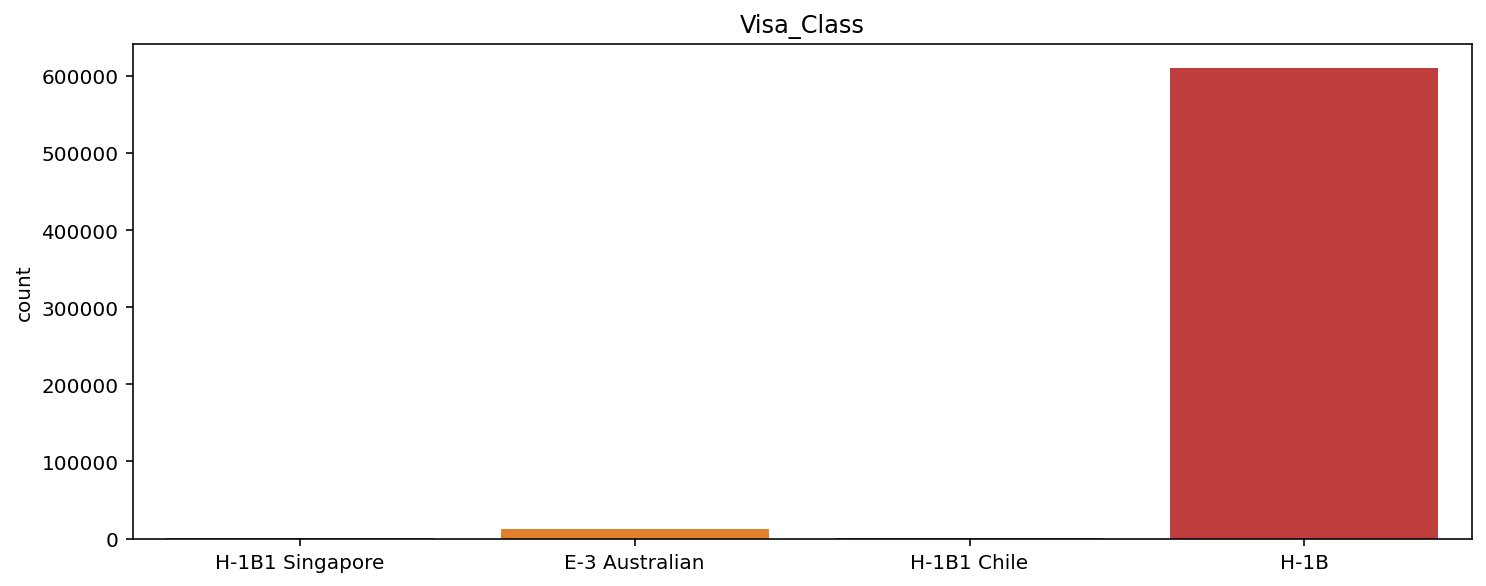

In [21]:
plt.figure(figsize=(12, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=X, x="Visa_Class", order=types).set_xlabel('')
plt.title("Visa_Class")


In [22]:
types = list(set(X["Case_bool"]))
print(len(types))
print(types)

1
['True']


Text(0.5, 1.0, 'Visa_Class')

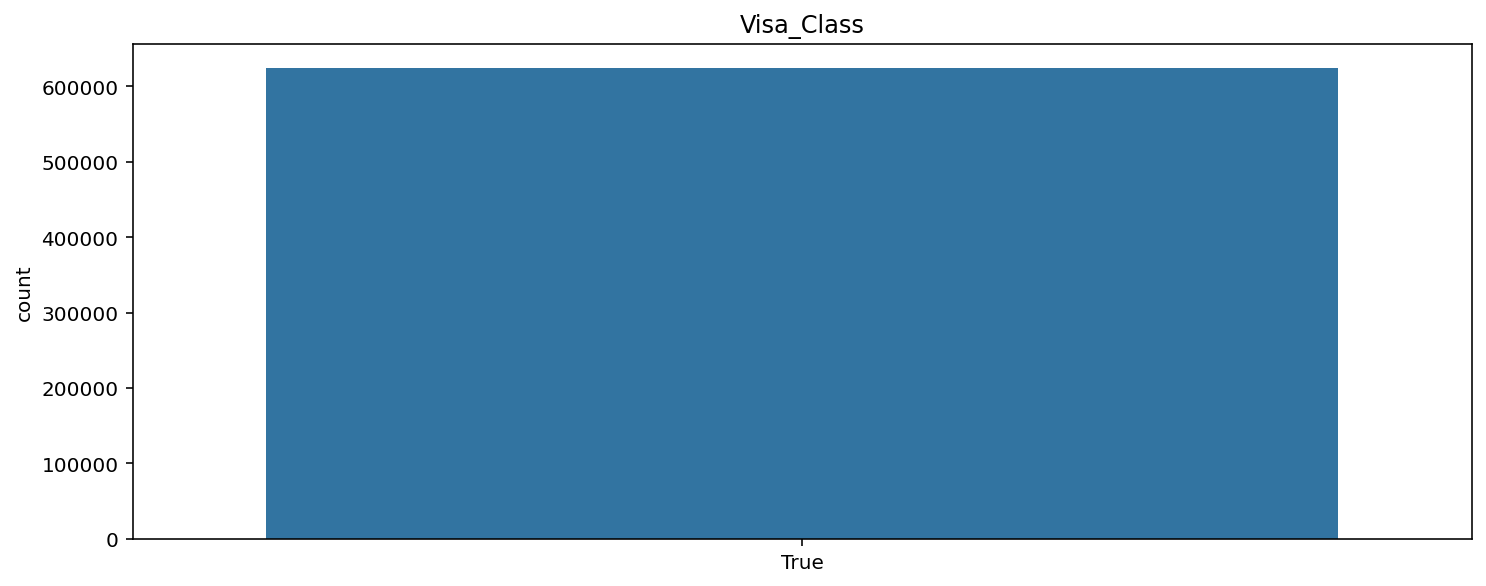

In [23]:
plt.figure(figsize=(12, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=X, x="Case_bool", order=types).set_xlabel('')
plt.title("Visa_Class")


소프트웨어 엔지니어, 기획자, 작가 등의 직군별, 비자 승인율 차이 분석


In [24]:
types = list(set(X["SOC_Title"]))
print(len(types))
print(types)

867
['Credit Analysts', 'Human Resources Specialist', 'Industrial-Organizational Psychologists', 'Water And Wastewater Treatment Plant And System', 'Drafters, All Other', 'Neurologists', 'Epidemiologists', 'Set And Exhibit Designers', 'Environmental Engineers', 'Software Engineers', 'Airfield Operations Specialists', 'Sales Representatives, Wholesale And Manufacturing', 'Community And Social Service Specialists, All', 'Artists And Related Workers, All Other', 'Network And Computer System Administrator', 'Market Research Analysts And Market Specialists', 'Actors', 'Secondary School Teachers', 'Life, Physical, And Social Science Technicians, Al', 'Engineers, All Other', 'Medical Scientist, Except Epidemiologist', 'Food Scientists And Technologists', 'Education, Training, And Library Workers, All Othe', 'Medical Technologists', 'System Developers, Applications, Non R&D', 'Web Developer', 'Hospitalists', 'Industrial Engineer', '15-1132', 'Network And Computer Systems Administrators*', 'Pro

소프트 웨어 엔지니어 : Computer Software Engineers, Applications ,Software Engineers,Computer Software Engineers, Applications Non R&D

Production, Planning, And Expediting Clerks

Writers And Authors

In [25]:
X[['SOC_Title','Case_bool']]
SOC_bool=X[['SOC_Title','Case_bool']]
SOC_bool

,SOC_Title,Case_bool
0,Computer Systems Analysts,True
1,Operations Research Analysts,True
2,Computer Programmers,True
3,"Computer Occupations, All Other",True
4,Credit Analysts,True
...,...,...
624645,"Software Developers, Applications",True
624646,Physicists,True
624647,"Geoscientists, Except Hydrologists And Geograp...",True
624648,Materials Engineers,True


In [26]:
SOC_bool['SOC_Title'].value_counts()

Software Developers, Applications               124489
Computer Systems Analysts                        93591
Computer Programmers                             66593
Computer Occupations, All Other                  53437
Software Developers, Systems Software            18400
                                                 ...  
Fine Artists                                         1
Quality Assurance Engineer                           1
17-2199                                              1
Agricultural Science Teachers, Postsecondary         1
Physcis Teachers, Postsecondary                      1
Name: SOC_Title, Length: 867, dtype: int64

In [27]:
cond1=(SOC_bool['SOC_Title']=='Computer Software Engineers, Applications')

In [28]:
SOC_bool.loc[cond1]

,SOC_Title,Case_bool
12024,"Computer Software Engineers, Applications",True
30757,"Computer Software Engineers, Applications",True
40206,"Computer Software Engineers, Applications",True
50981,"Computer Software Engineers, Applications",True
62748,"Computer Software Engineers, Applications",True
120750,"Computer Software Engineers, Applications",True
238634,"Computer Software Engineers, Applications",True
312865,"Computer Software Engineers, Applications",True
373632,"Computer Software Engineers, Applications",True
374076,"Computer Software Engineers, Applications",True


In [29]:
len(SOC_bool.loc[cond1])

14

In [30]:
12/14

0.8571428571428571

In [31]:
cond1=(SOC_bool['SOC_Title']=='Production, Planning, And Expediting Clerks')

In [32]:
SOC_bool.loc[cond1]

,SOC_Title,Case_bool
20117,"Production, Planning, And Expediting Clerks",True
24381,"Production, Planning, And Expediting Clerks",True
24664,"Production, Planning, And Expediting Clerks",True
30058,"Production, Planning, And Expediting Clerks",True
89903,"Production, Planning, And Expediting Clerks",True
106717,"Production, Planning, And Expediting Clerks",True
165516,"Production, Planning, And Expediting Clerks",True
181838,"Production, Planning, And Expediting Clerks",True
216334,"Production, Planning, And Expediting Clerks",True
275769,"Production, Planning, And Expediting Clerks",True


In [33]:
22/24

0.9166666666666666

In [34]:
cond1=(SOC_bool['SOC_Title']=='Writers And Authors')
cond2=(SOC_bool['Case_bool']=='False')

In [35]:
SOC_bool.loc[cond1]

,SOC_Title,Case_bool
4775,Writers And Authors,True
17423,Writers And Authors,True
21290,Writers And Authors,True
23084,Writers And Authors,True
26534,Writers And Authors,True
...,...,...
603892,Writers And Authors,True
613477,Writers And Authors,True
613887,Writers And Authors,True
618087,Writers And Authors,True


In [36]:
122/128

0.953125

In [37]:
X.dtypes

Visa_Class             object
Employer_Name          object
SOC_Title              object
Full_Time_Position     object
Worksite               object
Prevailing_Wage       float64
Unit_Of_Pay            object
Employer_Location      object
Case_Status            object
Case_bool              object
dtype: object